# MIS 583 Assignment 3: Semi-supervised Flower Classfication

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 鄔仁迪, B104020009.

## Semi-supervised Flower Classfication

In this approach, you have a dataset that includes both labeled and unlabeled examples.

The goal is to use the labeled data to train the model while also leveraging the unlabeled
data to improve the model's performance.

In this assignment, you’ll explore a self-training mechanism for this task.


**Please note that you’re not allowed to use pre-constructed models or pre-trained weights.**

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish datasets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/e304bb12c8a84e5c9c1b27a6c3bd4026) to join the competition.

**Again, Use your SID as your team's name!!!**

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python==3.10.12`, `torch==2.0.1+cu118` and `torchvision==0.15.2+cu118`. This is the default version in Google Colab.

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
torch 2.1.0+cu118
torchvision 0.16.0+cu118


# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  

This dataset contains 4317 flower images.   
**IMPORTANT: you CANNOT use any extra images.**

The data collection is grabed from the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

The pictures are divided into five classes: 
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## How to Get Data

請先到共用雲端硬碟將檔案 `A3_data_flower_2023.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/11mOkJbDfuqBzoiFSSdHIZw41OmOXtB2p/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

Unzip `A3_data_flower_2023.zip`, there are 2 folders and 4 csvs.

- `train/`: contains 5 folders for 5 categories of flowers. Images of flowers inside them.
- `test/`: unclassified images of testing set.
- `train_labeled_dataset.csv`: file path and true label of training set.
- `train_unlabeled_dataset.csv`: file path and without label of training set.
- `val.csv`: file path and true label of validation set.
- `test.csv`: file paht of testing set.

There are **854 images in labeled_dataset_train.**  

There are **1735 images in unlabeled_dataset_train.** 

There are **864 images in dataset_test.**  

There are **864 images in dataset_val.**  

---

解壓縮 `A3_data_flower_2023.zip` 後可以發現裡面有兩個資料夾和四個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train_labeled_dataset.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `train_unlabeled_dataset.csv` : 讀取 train data 的順序、路徑與圖片但沒有所屬花別標籤。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train_labeled`的圖片 854 張，`train_unlabeled`的圖片 1735 張，`val` 的圖片 864 張，`test` 的圖片 864 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [2]:
# !unzip -qq ./drive/MyDrive/A3_data_flower_2023.zip

In [3]:
data_folder = 'A3_data_flower_2023'

## Loading the dataset

### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.
Implement `__init__`, `__getitem__` and `__len__` 3 functions.

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

---

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [4]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{data_folder}/{row['file_path']}")
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = int(self.labels[index])

        return data, label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [5]:
from torchvision import transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
# These calculate from data eval
train_mean = [0.4234, 0.3785, 0.2925]
train_std = [0.2588, 0.2345, 0.2227]

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),                                              # Random crop and resize
    transforms.RandomHorizontalFlip(),                                              # Random horizontal flip
    transforms.RandomRotation(30),                                                  # Random rotation
    transforms.ToTensor(),                                                          # Convert to tensor
    transforms.Normalize(mean=train_mean, std=train_std)                            # Normalize
])
############################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = transforms.Compose([
    transforms.Resize(256),                               # Resize to a fixed size
    transforms.CenterCrop(224),                           # Center crop
    transforms.ToTensor(),                                # Convert to tensor
    transforms.Normalize(mean=train_mean, std=train_std)  # Normalize
])
########################################################################
#                           End of your code                           #
########################################################################

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ train_set: for labeled_training.
+ unlabeled_set: for unlabeled_training.
+ dataset_val: for validation.

In [6]:
train_set = FlowerData('train_labeled_dataset.csv', mode='train', transform=transforms_train)
unlabeled_set = FlowerData('train_unlabeled_dataset.csv', mode='test', transform=transforms_train)
valid_set = FlowerData('val.csv', mode='val', transform=transforms_test)

In [7]:
print("The first image's shape in dataset_train :", train_set[0][0].size())
print("There are", len(train_set), "images in labeled_dataset_train.")
print("There are", len(unlabeled_set), "images in unlabeled_dataset_train.")
print("There are", len(valid_set), "images in dataset_val.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 854 images in labeled_dataset_train.
There are 1735 images in unlabeled_dataset_train.
There are 864 images in dataset_val.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [8]:
#####################################################
#            You can adjust batch_size              #
#####################################################
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 0
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Self-training

## Step 1: Supervised training

### Implement CNN using PyTorch 

Try to use labeled data design and train a deep convolutional network from scratch to predict the class label of a flower image. 

**Again, the goal of this assignment is for you to test different convolutional structures. You cannot directly use the blocks/architectures of pre-trained models.**

In [48]:
from torch.nn.modules.conv import Conv2d
import torch.nn as nn 
import torch.nn.functional as F

class YourCNNModel(nn.Module):
    def __init__(self): 
        super().__init__()
        ########################################################################
        #     TODO: use nn.xxx method to generate a CNN model part             #
        ########################################################################
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Mobile Inverted Bottleneck Convolution Blocks
        self.blocks = nn.Sequential(
            self.MBConv_block(32, 16, 3, 1, 1, 1),
            self.MBConv_block(16, 24, 3, 1, 2, 2),
            self.MBConv_block(24, 40, 5, 2, 2, 2),
            self.MBConv_block(40, 80, 3, 1, 2, 3),
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(80, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout()
        )
        self.out = nn.Linear(512, 5)

    def MBConv_block(self, in_channels, out_channels, kernel_size, padding, stride, num_layers):
        # The first layer is a point-wise convolution to expand the number of channels
        layers = [nn.Conv2d(in_channels, in_channels * 6, kernel_size=1, stride=1, padding=0, bias=False),
                  nn.BatchNorm2d(in_channels * 6), nn.ReLU()]

        # Depth-wise separable convolutions with multiple layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels * 6, bias=False))
            layers.append(nn.BatchNorm2d(in_channels * 6))
            layers.append(nn.ReLU())

        # The last layer is a point-wise convolution to reduce the number of channels to the desired output size
        layers.append(nn.Conv2d(in_channels * 6, out_channels, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

        return nn.Sequential(*layers)
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
          x = torch.Tensor(x)
        ########################################################################
        #     TODO: forward your model and get output                          #
        ########################################################################
        # Forward pass through convolutional layers
        x = self.conv1(x)
        x = self.blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out = self.out(x)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

In [49]:
device = torch.device('cuda')
# or
# device = torch.device('cpu')

In [50]:
from torchvision.models import resnet34

model = YourCNNModel()
model.to(device)
#print(model)

YourCNNModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
      (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, aff

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [51]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
# CrossEntropyLoss for classification tasks
criterion = nn.CrossEntropyLoss()

# Adam optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max) or [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [52]:
def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for images, labels in input_data:
        images = images.to(device)
        labels = labels.to(device)

        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        # Get the counts of correctly classified images
        _, predicted = torch.max(outputs.data, 1)
        total_count += labels.size(0)
        acc_count += (predicted == labels).sum().item()
        loss_list.append(loss.item())
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [53]:
def val(input_data, model, criterion):
    model.eval()

    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for images, labels in input_data:
            images = images.to(device)
            labels = labels.to(device)

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            # Get the predicted result and loss
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Get the counts of correctly classified images
            _, predicted = torch.max(outputs.data, 1)
            total_count += labels.size(0)
            acc_count += (predicted == labels).sum().item()
            loss_list.append(loss.item())
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [54]:
################################################################################
#     You can adjust those hyper parameters to loop for max_epochs times       #
################################################################################
max_epochs = 300
log_interval = 1
early_stopping_patience = 20    # Number of epochs to wait for improvement

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

best_val_loss = torch.inf       # Initialize with a large value
no_improvement_count = 0

best_model_state_dict = None    # To store the state_dict of the best model

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(valid_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

    # Check for early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0

        # Save a copy of the model's state_dict when the best validation loss is seen
        best_model_state_dict = model.state_dict()
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')

        # Restore the best model weights
        if best_model_state_dict is not None:
            model.load_state_dict(best_model_state_dict)
        break

################################################################################
#                               End of your code                               #
################################################################################

==================== Epoch 1 ====================
Train Acc: 0.198598 Train Loss: 1.827879
  Val Acc: 0.244213   Val Loss: 1.645254
==================== Epoch 2 ====================
Train Acc: 0.245327 Train Loss: 1.758144
  Val Acc: 0.269676   Val Loss: 1.640839
==================== Epoch 3 ====================
Train Acc: 0.225467 Train Loss: 1.754664
  Val Acc: 0.281250   Val Loss: 1.606595
==================== Epoch 4 ====================
Train Acc: 0.251168 Train Loss: 1.692023
  Val Acc: 0.276620   Val Loss: 1.597675
==================== Epoch 5 ====================
Train Acc: 0.273364 Train Loss: 1.665959
  Val Acc: 0.278935   Val Loss: 1.609919
==================== Epoch 6 ====================
Train Acc: 0.311916 Train Loss: 1.610539
  Val Acc: 0.303241   Val Loss: 1.549075
==================== Epoch 7 ====================
Train Acc: 0.339953 Train Loss: 1.567522
  Val Acc: 0.335648   Val Loss: 1.557856
==================== Epoch 8 ====================
Train Acc: 0.323598 Train 

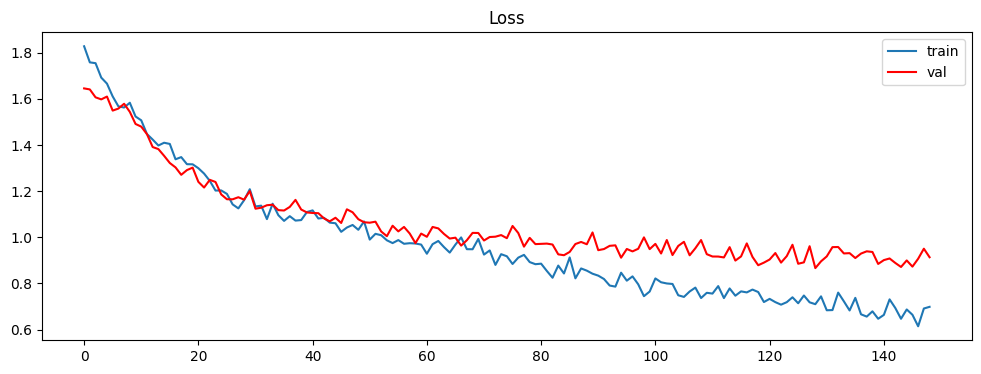

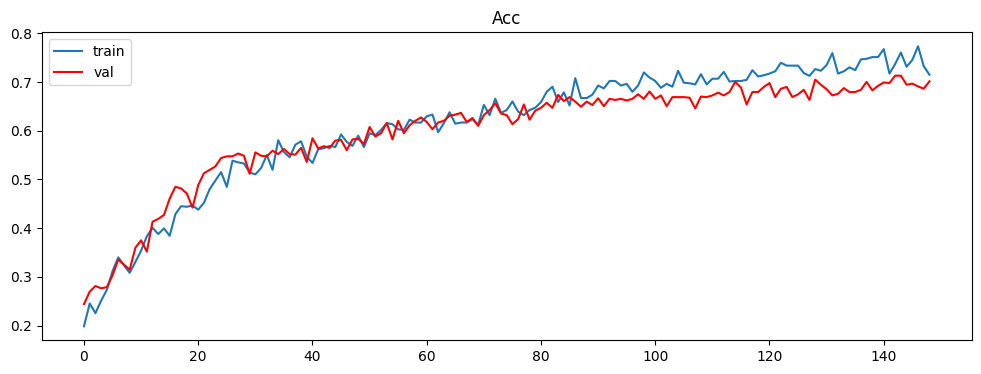

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

In [56]:
from datetime import datetime

# save your well-trained state_dict of model
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
torch.save(model.state_dict(), f'MB-CONV_{timestamp}.pt')

finish training your classifier, next you should use this classifer to predict unlabel images with pseduo label.

## Step2: Use unlabeled data to enhance model performance

In [58]:
# load the trained classifier weights
ckpt = torch.load('MB-CONV_2023-10-15-12-48.pt')
model.load_state_dict(ckpt) 

<All keys matched successfully>

In [60]:
# create a unlabeled data set list, we will use it later
unlabeled_set_list = []

for img in unlabeled_set:
    unlabeled_set_list.append(img)
    
print(len(unlabeled_set_list))

1735


i### Define loss and optimizer

In [61]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
# CrossEntropyLoss for classification tasks
criterion = nn.CrossEntropyLoss()

# Adam optimizer
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

### Use the trained classifier to generates pseudo-labels of a dataset.

In [62]:
from torch.utils.data import ConcatDataset, DataLoader, Subset
from tqdm.auto import tqdm

###########################################################
#   You can adjust the threshold to get better result !   #                                  
###########################################################
def get_pseudo_labels(model, threshold=0.5):
    
    global unlabeled_set_list, train_set
    
    remove_index, index = [], 0

    model.eval()
    
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for img in tqdm(unlabeled_set_list):
        
        #####################################################################################
        #     TODO:                                                                         #
        #     1. Foward the data, Using torch.no_grad() accelerates the forward process     #
        #     2. obtain the probability distributions by applying softmax on logits         #
        #     3. Filter the data with threshold                                             #
        #     4. Combine the labeled training data with the pseudo-labeled data             #
        #        to construct a new training set. then removed                              #
        #     5. the unlabeled data from unlabeled_set_list                                 #
        #     hint: ConcatDataset                                                           #
        ##################################################################################### 
        with torch.no_grad():
            img = img.to(device)  # Move the image to the device (e.g., GPU)

            # 1. Forward the data
            outputs = model(img.unsqueeze(0))  # Unsqueeze to add batch dimension

            # 2. Obtain the probability distributions by applying softmax on logits
            probs = softmax(outputs)

            # 3. Filter the data with the threshold
            max_prob, predicted_label = torch.max(probs, 1)

            if max_prob.item() >= threshold:
                # 4. Add the pseudo-label and image for the train set.
                train_set.data_list.append(unlabeled_set.data_list[index])
                train_set.labels.append(predicted_label.item())

                # 5. Remove the unlabeled data from unlabeled_set_list
                remove_index.append(index)

            index += 1
        #####################################################################################
        #                           End of your code                                        #
        #####################################################################################

     
    remove_index.reverse()
    for i in remove_index:
        del unlabeled_set_list[i]

    print(f"[{len(train_set)-854}/1735] images have been labeled.")
    
    # # Turn off the eval mode.
    model.train()

### Train the model

Let's define train function.  

Use the **get_pseudo_labels** function to get the new training set, then construct a new data loader for training.

It will iterate input data 1 epoch and update model with optmizer.  

Finally, calculate mean loss and total accuracy.

In [63]:
import sys
sys.setrecursionlimit(1000000)
#########################################################################################################
#         You can adjust those hyper parameters like epochs or threshlod for training                   #
#########################################################################################################
n_epochs = 10
best_acc = 0


for epoch in range(n_epochs):

    #########################################################################################################
    #    TODO:                                                                                              #
    #    In each epoch, relabel the unlabeled dataset for semi-supervised learning.                         #
    #    1. Obtain pseudo-labels for unlabeled data using trained model.(use get_pseudo_labels function)    #
    #    2. Construct a new dataset and a data loader for training.                                         #
    #    You can try different way to use the get_pseudo_label function maybe will get the better result.   #                                  #
    #########################################################################################################
    global train_set
    train_set = FlowerData('train_labeled_dataset.csv', mode='train', transform=transforms_train)
    get_pseudo_labels(model, threshold=0.85)

    # Create a new data loader for training
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    #########################################################################################################  
    #                                          End of your code                                             #
    #########################################################################################################

    # ---------- Training ----------
    model.train()
    
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        imgs, labels = batch

        logits = model(imgs.to(device))
        
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()

        loss.backward()

        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    model.eval()

    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):

        imgs, labels = batch

        with torch.no_grad():
          logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_acc_last = valid_acc

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'NAME_OF_SELF_TRAINING_EXPERIMENT.pt')
        print('[{:03d}/{:03d}] saving model with acc {:.3f}'.format(epoch + 1, n_epochs, best_acc))
#########################################################################################################
#                               End of your code                                                        #
#########################################################################################################
    

  0%|          | 0/1735 [00:00<?, ?it/s]

[620/1735] images have been labeled.


  0%|          | 0/47 [00:00<?, ?it/s]

[ Train | 001/010 ] loss = 0.55709, acc = 0.78856


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/010 ] loss = 0.88385, acc = 0.70370
[001/010] saving model with acc 0.704


  0%|          | 0/1115 [00:00<?, ?it/s]

[104/1735] images have been labeled.


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 002/010 ] loss = 0.91817, acc = 0.70889


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/010 ] loss = 0.86258, acc = 0.70602
[002/010] saving model with acc 0.706


  0%|          | 0/1011 [00:00<?, ?it/s]

[38/1735] images have been labeled.


  0%|          | 0/28 [00:00<?, ?it/s]

[ Train | 003/010 ] loss = 0.73668, acc = 0.72162


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/010 ] loss = 0.86549, acc = 0.70486


  0%|          | 0/973 [00:00<?, ?it/s]

[15/1735] images have been labeled.


  0%|          | 0/28 [00:00<?, ?it/s]

[ Train | 004/010 ] loss = 0.64987, acc = 0.76406


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/010 ] loss = 0.85607, acc = 0.71181
[004/010] saving model with acc 0.712


  0%|          | 0/958 [00:00<?, ?it/s]

[20/1735] images have been labeled.


  0%|          | 0/28 [00:00<?, ?it/s]

[ Train | 005/010 ] loss = 0.65008, acc = 0.78103


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/010 ] loss = 0.84689, acc = 0.71296
[005/010] saving model with acc 0.713


  0%|          | 0/938 [00:00<?, ?it/s]

[5/1735] images have been labeled.


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 006/010 ] loss = 0.60130, acc = 0.76462


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/010 ] loss = 0.83498, acc = 0.71991
[006/010] saving model with acc 0.720


  0%|          | 0/933 [00:00<?, ?it/s]

[7/1735] images have been labeled.


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 007/010 ] loss = 0.61520, acc = 0.76373


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/010 ] loss = 0.84370, acc = 0.71644


  0%|          | 0/926 [00:00<?, ?it/s]

[26/1735] images have been labeled.


  0%|          | 0/28 [00:00<?, ?it/s]

[ Train | 008/010 ] loss = 0.71044, acc = 0.76451


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/010 ] loss = 0.83393, acc = 0.70833


  0%|          | 0/900 [00:00<?, ?it/s]

[9/1735] images have been labeled.


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 009/010 ] loss = 0.60624, acc = 0.76826


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/010 ] loss = 0.83379, acc = 0.70718


  0%|          | 0/891 [00:00<?, ?it/s]

[2/1735] images have been labeled.


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 010/010 ] loss = 0.58870, acc = 0.78318


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/010 ] loss = 0.83653, acc = 0.70486


In [65]:
# save your well-trained state_dict of model
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
torch.save(model.state_dict(), f'MB-CONV_Self_Train_{timestamp}.pt')

### Predict Result

Predict the labesl based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/e304bb12c8a84e5c9c1b27a6c3bd4026).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/e304bb12c8a84e5c9c1b27a6c3bd4026)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [64]:
# if you wanna load previous best model
ckpt = torch.load('NAME_OF_SELF_TRAINING_EXPERIMENT.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [66]:
test_set = FlowerData('test.csv', mode='test', transform=transforms_test)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [67]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [68]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'label'])
    writer.writeheader()
    for result in output_csv:
        file_path = test_set.data_list[idx].replace(data_folder + '/', '')
        writer.writerow({'file_path':file_path, 'label':result})
        idx += 1